# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# II. Business Understanding:
### Problem Statement:
* What are the gender, age, and income distributions of clients in general?
* What are the distributions of offer types by gender, age, and household income of consumers who completed the offers?
* Will a client take advantage of a deal?

# III. Data Understanding:

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
sns.set_palette('Set2')

In [3]:
portfolio.head(20)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.shape

(10, 6)

In [6]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [11]:
transcript.shape

(306534, 4)

In [12]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# III. Data Preparation:

We must first prepare the data for analysis and modeling in order to proceed and answer the problem statement question. This will be accomplished by cleaning each dataset and then integrating them using suitable ids.

In [13]:
def clean_portfolio_dataset(df):
    """
    args:
        df (Dataframe): the offers portfolio dataset dataframe
    
    return:
        df (Dataframe): the cleaned offers portfolio dataset dataframe
    """
    
    # before wrangling the data, copy the dataframe.
    df = df.copy()
    
    # get the list of unique 'channels'
    channels = set()    
    for row in df.channels:
        channels = channels.union(set(row))
    
    # in the 'channels' column, construct binary columns for each channel
    for channel in channels:
        df[channel] =  df['channels'].apply(lambda x: 1 if channel in x else 0)
    
    # in the 'offer type' column, establish dataframe binary columns for each offer type
    df_offer_type = pd.get_dummies(df['offer_type'])
    
    # in the 'offer type' column, merge dataframe binary columns from each offer type with cleaned original dataframe
    df = pd.concat([df, df_offer_type], axis=1)
    
    # remove the columns 'offer type' and 'channels' from the cleaned original dataframe
    df.drop(['channels'], axis = 1, inplace=True)
    
    # drop duplicates
    print("Duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("Duplicates after dropping: ", df.duplicated().sum())
    
    
    # rename 'id' column to 'offer_id'
    df.rename(columns={'id':'offer_id'}, inplace=True)
    
    return df

clean_portfolio = clean_portfolio_dataset(portfolio)
clean_portfolio

Duplicates:  0


,reward,difficulty,duration,offer_type,offer_id,web,social,mobile,email,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,1,0,1,0


In [14]:
def clean_profile_dataset(df):
    """ 
    args:
        df (Dataframe): the profile dataset dataframe
    
    return:
        df (Dataframe): the cleaned profile dataset dataframe
    """
    
    # before wrangling the data, copy the dataframe.
    df = df.copy()
    
    # drop duplicates
    print("duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("duplicates after dropping: ", df.duplicated().sum())
        
    # convert 'became_member_on' column type to date
    df['became_member_on'] = df['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d') )
    
    # construct binary columns in a dataframe for each gender in the 'gender' column
    df_gender = pd.get_dummies(df['gender'], prefix="gender_")
    
    # in the 'gender' column, merge dataframe binary columns from each gender with the cleaned original dataframe
    df = pd.concat([df, df_gender], axis=1)
    
    # instead of 118, put the missing date in the 'age' column to nan.
    df['age'] = df['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # sort customers into their appropriate age groups.
    df['age_category']  = pd.cut(df['age'], bins=[18,35,55,118], labels=['young-adult','adult','elderly'], right=False)
    
    # construct binary columns in a dataframe for each gender in the 'gender' column
    df_ageCategory = pd.get_dummies(df['age_category'])
    
    # in the 'gender' column, merge dataframe binary columns from each gender with the cleaned original dataframe
    df = pd.concat([df, df_ageCategory], axis=1)
    
    # change the name of the 'id' column to 'user id'.
    df.rename(columns={'id':'user_id'}, inplace=True)
    
    return df

clean_profile = clean_profile_dataset(profile)

duplicates:  0


In [15]:
clean_profile

,gender,age,user_id,became_member_on,income,gender__F,gender__M,gender__O,age_category,young-adult,adult,elderly
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,0,0,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,elderly,0,0,1
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,NaN,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,elderly,0,0,1
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1,0,0,adult,0,1,0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,1,0,elderly,0,0,1
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,adult,0,1,0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0,elderly,0,0,1


In [16]:
def value_to_transaction(transcript):
    """     
    args:
       transcript (Series): row from transcript datafteme
    
    return:
       float as transaction_amount or NaN
    """
    if transcript['event'] == 'transaction':
        return transcript['value']['amount']
    else:
        return np.nan
        
def value_to_offer_id(transcript):
    """
    args:
       transcript (Series): row from transcript datafteme
    
    return:
        String as offer_id or NaN
    """
    if transcript['event'] != 'transaction':
        if 'offer id'in transcript['value'].keys() :
            return transcript['value']['offer id']
        else:
            return transcript['value']['offer_id']
    else:
        return None


def clean_transcript_dataset(df):
    """    
    args:
        df (Dataframe): the offers transcript dataset dataframe
    
    return:
        df (Dataframe): the cleaned dataset
    """
    
    # before wrangling the data, copy the dataframe.
    df = df.copy()
    
    # Add null values to the 'offer id' and 'transaction amount' columns.
    df['offer_id'] = None
    df['transaction_amount'] = np.nan
    
    # extract values from the 'transaction amount' column from the values in the 'value' column
    df['transaction_amount'] = df.apply(lambda row : value_to_transaction(row),axis=1)
    
    # extract values from the 'offer id' column from the values in the 'value' column
    df['offer_id'] = df.apply(lambda row : value_to_offer_id(row),axis=1)
    
    
    # construct binary columns in a dataframe from each transcript event in 'event' 
    df_event = pd.get_dummies(df['event'])
    
    # merge binary columns in a dataframe from each transcript event in 'event'
    df = pd.concat([df, df_event], axis=1)
    
    # from the cleaned original dataframe, remove the 'value' and 'event' columns
    df.drop(['value'], axis = 1, inplace=True)
    
    # Get rid of duplicates
    print("Duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("Duplicates after dropping: ", df.duplicated().sum())
    
    # Change the name of the 'person' column to 'uesr id'.
    df.rename(columns={'person':'user_id'}, inplace=True)
    
    return df

clean_transcript = clean_transcript_dataset(transcript)



Duplicates:  397
Duplicates after dropping:  0


In [17]:
clean_transcript.head()
clean_transcript[clean_transcript['event']== 'offer completed' ].head()

,user_id,event,time,offer_id,transaction_amount,offer completed,offer received,offer viewed,transaction
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,NaN,1,0,0,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,1,0,0,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1,0,0,0


In [18]:
# merge clean_transcript and clean_portfolio on offer_id
df_starbucks_master = clean_transcript.merge(clean_portfolio,on='offer_id',how='left')
# merge the merged clean_transcript with clean_portfolio datasets to clean_profile on user_id
df_starbucks_master = df_starbucks_master.merge(clean_profile,on='user_id',how='left')
df_starbucks_master.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306136
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   user_id             306137 non-null  object        
 1   event               306137 non-null  object        
 2   time                306137 non-null  int64         
 3   offer_id            167184 non-null  object        
 4   transaction_amount  138953 non-null  float64       
 5   offer completed     306137 non-null  uint8         
 6   offer received      306137 non-null  uint8         
 7   offer viewed        306137 non-null  uint8         
 8   transaction         306137 non-null  uint8         
 9   reward              167184 non-null  float64       
 10  difficulty          167184 non-null  float64       
 11  duration            167184 non-null  float64       
 12  offer_type          167184 non-null  object        
 13  web                 167184 no

In [19]:
df_starbucks_master.head()

,user_id,event,time,offer_id,transaction_amount,offer completed,offer received,offer viewed,transaction,reward,...,age,became_member_on,income,gender__F,gender__M,gender__O,age_category,young-adult,adult,elderly
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,5.0,...,75.0,2017-05-09,100000.0,1,0,0,elderly,0,0,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,5.0,...,NaN,2017-08-04,NaN,0,0,0,NaN,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,2.0,...,68.0,2018-04-26,70000.0,0,1,0,elderly,0,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,2.0,...,NaN,2017-09-25,NaN,0,0,0,NaN,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,10.0,...,NaN,2017-10-02,NaN,0,0,0,NaN,0,0,0


# IV. Data Analysis & Modeling:

## Data Analysis
* What are the gender, age, and income distributions of clients in general?
* What are the distributions of offer types by gender, age, and household income of consumers who completed the offers?
* Will a client take advantage of a deal?

### What are the gender, age, and income distributions of clients in general?

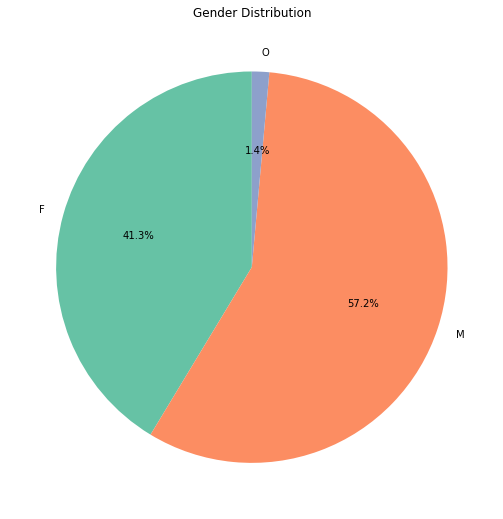

In [20]:
pie = clean_profile.groupby('gender').user_id.count().plot(kind='pie' ,figsize=(9,9)  , startangle=90, autopct='%1.1f%%' , title= "Gender Distribution").set_ylabel("");

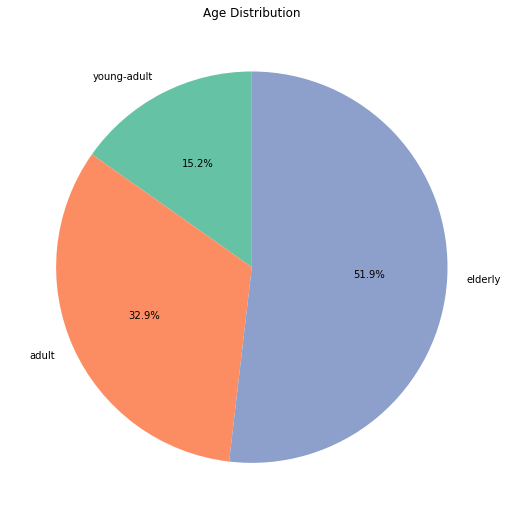

In [21]:
pie = clean_profile.groupby('age_category').user_id.count().plot(kind='pie' ,figsize=(9,9)  , startangle=90, autopct='%1.1f%%' , title= "Age Distribution").set_ylabel("");

C:\Users\omadz\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


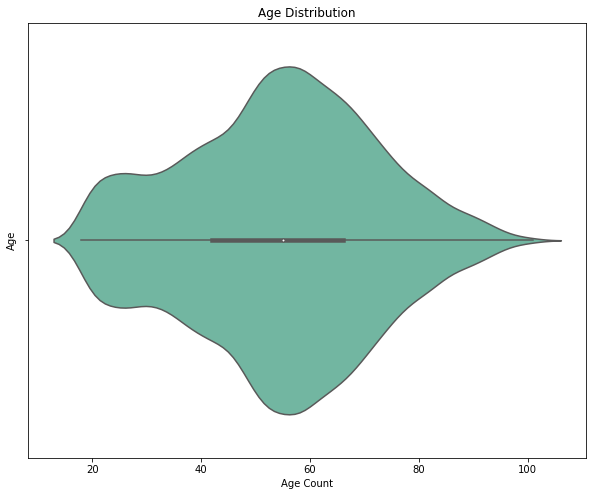

In [22]:
plt.figure(figsize=(10, 8))
sns.violinplot(clean_profile['age'], orient='h')

plt.title('Age Distribution')
plt.xlabel('Age Count')
plt.ylabel('Age');

In [23]:
clean_profile.age.mean()

54.39352445193929

C:\Users\omadz\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


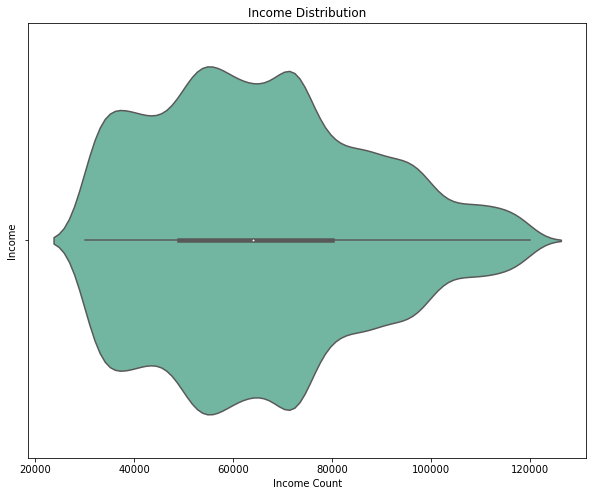

In [24]:
plt.figure(figsize=(10, 8))
sns.violinplot(clean_profile['income'], orient='h')

plt.title('Income Distribution')
plt.xlabel('Income Count')
plt.ylabel('Income');

In [25]:
clean_profile.income.mean()

65404.9915682968

### The income distribution in the profile dataset shows that the average income is $65,400, with the majority of profiles having incomes that are below the average.

In [26]:
df_starbucks_master_offer_completed = df_starbucks_master[transcript.event == 'offer completed']

C:\Users\omadz\AppData\Local\Temp/ipykernel_19324/1885426756.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_starbucks_master_offer_completed = df_starbucks_master[transcript.event == 'offer completed']


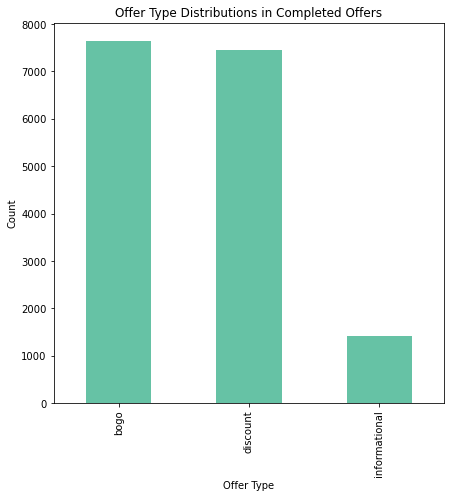

In [27]:
bar = df_starbucks_master_offer_completed.groupby('offer_type')['offer completed'].count().plot(kind='bar' ,figsize=(7,7)  , title= "Offer Type Distributions in Completed Offers");
bar.set_xlabel("Offer Type")
bar.set_ylabel("Count");

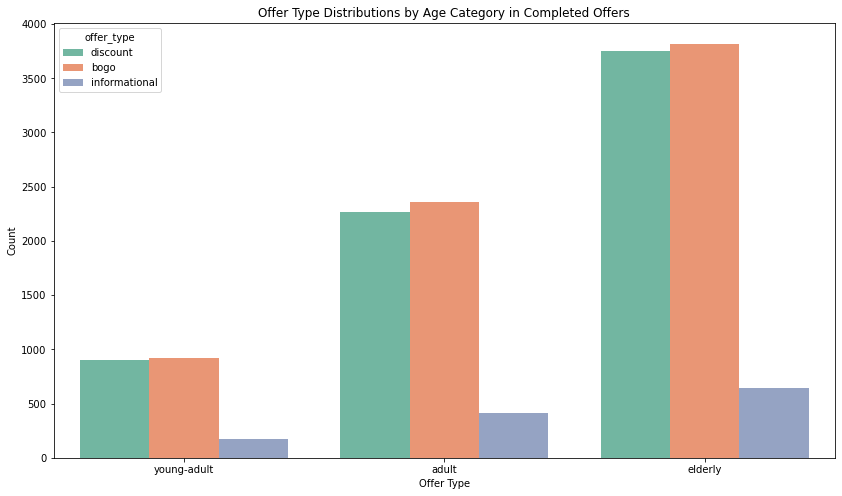

In [28]:
plt.figure(figsize=(14, 8))
sns.countplot(x="age_category", hue="offer_type", data=df_starbucks_master_offer_completed)
plt.title( "Offer Type Distributions by Age Category in Completed Offers");
plt.xlabel("Offer Type")
plt.ylabel("Count");

### As you can see, the elderly have the highest offer completion rates, with Bogo offers being the most popular, followed by Discount offers, and finally Informational offers. Adults come in second with the most offer completion counts, followed by young adults, who have the same offer types distribution as the elderly.

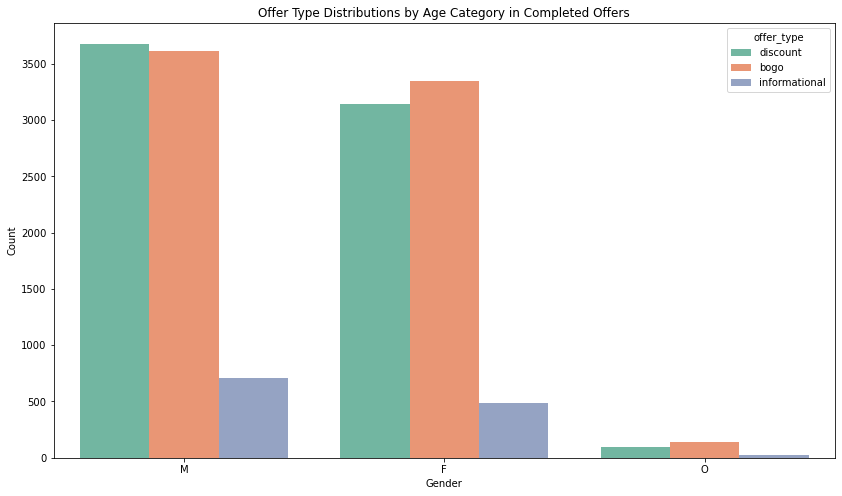

In [29]:
plt.figure(figsize=(14, 8))
sns.countplot(x="gender", hue="offer_type", data=df_starbucks_master_offer_completed)
plt.title( "Offer Type Distributions by Age Category in Completed Offers");
plt.xlabel("Gender")
plt.ylabel("Count");

### As you can see the males have the highest offer completion counts with Discount offers are the most popular offers followed closely by Bogo offers then Informational offer.  Follows the males in the highest offer completion counts are the females then 'other's both have the have offer types distribution as Bogo offers are the most popular offers followed closely by Discount offers then Informational offer.

In [30]:
df_starbucks_master_offer_completed.groupby('offer_type')['offer completed'].count()

offer_type
bogo             7649
discount         7459
informational    1420
Name: offer completed, dtype: int64

# Data Modeling:

### - Will a client take advantage of a deal?

We'll seek for transcripts where the customer has viewed the offer in the merged data set (df starbucks master) and utilize the 'offer finished' as the model's goal, removing any transaction-related columns and rows.

We begin by retrieving offer completed and offer viewed rows, then combining them:

In [31]:
# get viewed offer rows
df_starbucks_master_offer_viewed = df_starbucks_master[df_starbucks_master['offer viewed']==1]
# drop offer completed column from offer viewed rows
df_starbucks_master_offer_viewed.drop(['offer completed'], axis = 1, inplace=True)

C:\Users\omadz\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
# get offer completed rows with three columns 'user_id', 'offer_id' and 'offer completed'
df_starbucks_master_offer_completed = df_starbucks_master[df_starbucks_master['offer completed']==1][['offer_id','user_id', 'offer completed']]
# get offer completed and offer viewed rows 
df_modeling = df_starbucks_master_offer_viewed.merge(df_starbucks_master_offer_completed,right_on=['offer_id','user_id'],left_on=['offer_id','user_id'],how='left')
# fill missing values in offer completed column with 0
df_modeling['offer completed'].fillna(0,inplace=True)
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65580 entries, 0 to 65579
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             65580 non-null  object        
 1   event               65580 non-null  object        
 2   time                65580 non-null  int64         
 3   offer_id            65580 non-null  object        
 4   transaction_amount  0 non-null      float64       
 5   offer received      65580 non-null  uint8         
 6   offer viewed        65580 non-null  uint8         
 7   transaction         65580 non-null  uint8         
 8   reward              65580 non-null  float64       
 9   difficulty          65580 non-null  float64       
 10  duration            65580 non-null  float64       
 11  offer_type          65580 non-null  object        
 12  web                 65580 non-null  float64       
 13  social              65580 non-null  float64   

#### We're going to start eliminating data columns now:

* gender: since the data was already extracted in three columns: gender F, gender M, and gender O.
* age_category and age: because the values had previously been retrieved and summarized in three different column categories: young adult, adult, and old
* offer_type: because the variables were already extracted into three columns: BOGO, discount, and informative
* event, offers received, offer viewed, and transaction: because we've already taken enough data to construct the modeling data frame
* transaction_amount: because they're solely concerned with transactional events
* user_id, offer_id, and became_member_on: because they wouldn't change the model in any way

In [33]:
dropped_columns = ['gender','age','age_category','became_member_on','event', 'offer_type',
                    'offer received', 'offer viewed' , 'transaction','transaction_amount',
                    'offer_id','user_id']

# removing data colunms
df_modeling.drop(dropped_columns, axis = 1, inplace=True)

# fill the missing values in income column with income column mean.
df_modeling.income.fillna(df_modeling.income.mean(), inplace=True)

df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65580 entries, 0 to 65579
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             65580 non-null  int64  
 1   reward           65580 non-null  float64
 2   difficulty       65580 non-null  float64
 3   duration         65580 non-null  float64
 4   web              65580 non-null  float64
 5   social           65580 non-null  float64
 6   mobile           65580 non-null  float64
 7   email            65580 non-null  float64
 8   bogo             65580 non-null  float64
 9   discount         65580 non-null  float64
 10  informational    65580 non-null  float64
 11  income           65580 non-null  float64
 12  gender__F        65580 non-null  uint8  
 13  gender__M        65580 non-null  uint8  
 14  gender__O        65580 non-null  uint8  
 15  young-adult      65580 non-null  uint8  
 16  adult            65580 non-null  uint8  
 17  elderly     

## Now to train and test the model:

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

KN  = KNeighborsClassifier()
DT  = DecisionTreeClassifier()
RF  = RandomForestClassifier()
MLP = MLPClassifier()
ADA = AdaBoostClassifier()
GNB = GaussianNB()
SVM = SVC()

# set the features data set
features = df_modeling.drop(['offer completed'], axis = 1)
# set the target data set
target = df_modeling['offer completed']
# split data set to training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

# create data frame that will store Classifieries results
df_classifiers_results = pd.DataFrame(columns = ['Classifier', 'Training Accuracy','Testing Accuracy'])

# set Classifieries in dict
classifiers = {    'KNeighbors' : KN,
            'Decision Tree' : DT,
            'Random Forest' : RF,
            'Neural Network' : MLP,
            'AdaBoost' : ADA,
            'Gaussian Naive Bayes' : GNB,
            'SVM' : SVM   }

# loop over Classifieries in dict
for classifiers_name, clf in classifiers.items():
    
    # train classifier
    trianed_classifiers = clf.fit( X_train , y_train )
    
    # predict on training dataset
    prediction_train = trianed_classifiers.predict( X_train )
    
    # predict on testing dataset
    prediction_test = trianed_classifiers.predict(X_test)
    
    # accuracy on training dataset
    accuracy_train = accuracy_score( y_train , prediction_train )
    
    # accuracy on testing dataset
    accuracy_test = accuracy_score( y_test , prediction_test )
    
    # set classifier result to dict
    classifiers_result = {'Classifier': classifiers_name, 'Training Accuracy': accuracy_train, 'Testing Accuracy' :accuracy_test}
    
    # display classifier clf_result dict 
    print(classifiers_result)
    # add classifier result to df_clfs_results dataframe
    df_classifiers_results = df_classifiers_results.append(pd.DataFrame(classifiers_result,index=[0]),ignore_index = True)



{'Classifier': 'KNeighbors', 'Training Accuracy': 0.8167937379282302, 'Testing Accuracy': 0.7377859103385178}
{'Classifier': 'Decision Tree', 'Training Accuracy': 0.9571820677035682, 'Testing Accuracy': 0.7547422994815493}
{'Classifier': 'Random Forest', 'Training Accuracy': 0.9571007420961676, 'Testing Accuracy': 0.7812747788960048}
{'Classifier': 'Neural Network', 'Training Accuracy': 0.7317881467927213, 'Testing Accuracy': 0.7257090576395242}
{'Classifier': 'AdaBoost', 'Training Accuracy': 0.8104096777472807, 'Testing Accuracy': 0.8036596523330284}
{'Classifier': 'Gaussian Naive Bayes', 'Training Accuracy': 0.7364643692182576, 'Testing Accuracy': 0.729551692589204}
{'Classifier': 'SVM', 'Training Accuracy': 0.5703974789061705, 'Testing Accuracy': 0.5645623665751753}


## Evaluation:

In this section, I'll assess the models' outcomes.

#### Metrics:

Because we're dealing with a straightforward classification problem, I've chosen Accuracy as the metric by which I'll assess my models. This is because we want to evaluate the ratio of correctly classified predictions to total predictions to see how well our models are performing.

In [35]:
df_classifiers_results

,Classifier,Training Accuracy,Testing Accuracy
0,KNeighbors,0.816794,0.737786
1,Decision Tree,0.957182,0.754742
2,Random Forest,0.957101,0.781275
3,Neural Network,0.731788,0.725709
4,AdaBoost,0.810410,0.803660
5,Gaussian Naive Bayes,0.736464,0.729552
6,SVM,0.570397,0.564562


#### KNeighbors, Decision Tree, and Random Forest have the highest difference in accuracy between the test and train accuracy, indicating that the models are overfitting, as seen in the table above. So I went with AdaBoost classifier since it produced the greatest results while I was looking for the optimum settings to improve my results.

In [36]:
from sklearn.model_selection import GridSearchCV
# set parameters for grid search  
parameters = {
 'n_estimators': [50, 100,150,200],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
    'algorithm':['SAMME', 'SAMME.R']
 }
    
# use grid search to find better parameters
model = GridSearchCV(ADA, param_grid=parameters, n_jobs = -1, scoring='accuracy')
model.fit(X_train,y_train)
print("best parameters:", model.best_params_)

best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 150}


In [37]:
# set Classifier
refined_ADA = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1, n_estimators=150)

# train classifier
trianed_classifiers = refined_ADA.fit(X_train, y_train)
    
# predict on training dataset
prediction_train = trianed_classifiers.predict(X_train)
    
# predict on testing dataset
prediction_test = trianed_classifiers.predict(X_test)
    
# accuracy on training dataset
accuracy_train = accuracy_score(y_train, prediction_train)
    
# accuracy on testing dataset
accuracy_test = accuracy_score(y_test, prediction_test)

classifiers_result = {'Classifier': 'AdaBoost', 'Training Accuracy': accuracy_train, 'Testing Accuracy' :accuracy_test}

print(classifiers_result)


{'Classifier': 'AdaBoost', 'Training Accuracy': 0.8106333231676324, 'Testing Accuracy': 0.8035986581274779}


In [38]:
print('Best parameters:', model.best_params_)
print('Training Accuracy: ',classifiers_result['Training Accuracy'], ', Testing Accuracy: ',classifiers_result['Testing Accuracy'])

Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 150}
Training Accuracy:  0.8106333231676324 , Testing Accuracy:  0.8035986581274779


# VI. Conclusion:

Finally, after reviewing the data, I discovered the following:

* BOGO offers are more popular since they have a higher completion rate and are followed by a discount offer, thus Starbucks may want to focus on delivering these sorts of deals.
* Because men are more likely to complete offers, Starbucks may wish to send them more offers.
* Because the elderly are more likely to complete offers, Starbucks may wish to send them additional offers.

In addition, the question that needed to be answered was whether or not a consumer would respond to an offer. am going to respond to it We went through the procedures below to answer the question using my method.

* Fetching completed offer and offer seen rows, then merging them.
* Removing data columns that aren't relevant to the model or that have been replaced by others.
* Splitting the dataset into two parts: training and testing.
* Testing and evaluating multiple train and test dataset techniques based on model correctness.
* Selecting the best model, then using grid search to fine-tune its parameters.

As a consequence, AdaBoost was the method that produced the best classification results, with an accuracy of 80.35 percent.

#  VII. Improvements:

To improve our outcomes even more, I believe consumer information was limited; we just had age, gender, and income. It would be preferable to have more client characteristics to determine which demographic groupings respond best to offers.